# Lizard Island Deployment Analysis
Yui Takeshita and team deployed a Self-Calibrating SeapHOx on the South Reef Flat at Lizard Island in Nov. 2019. This analysis is intended to accompany a manuscript in preparation to describe the SCS.

### Prep
Import necessary modules and read in Yui's data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from PyCO2SYS import CO2SYS
import gsw

# Read in CSVs generated from Yui's .mat file
df_spec = pd.read_csv('../Data/auto_table_revised20200603.csv', parse_dates = [0], index_col = 0) # spectrophotometric pH and total alkalinity of discrete samples
df_SCS = pd.read_csv('../Data/scsp_table.csv', parse_dates = [1], index_col = 1) # Self-Calibrating SeapHOx data file
df_tris = pd.read_csv('../Data/tris_table.csv', parse_dates = [1], index_col = 1) # tris data, extracted from SCS

### Drop NaN-containing rows
For this analysis, we mainly need pHspec (AKA pH20) so drop rows without it.

In [2]:
df_spec.dropna(subset=['pH20'], inplace = True)
print("There are {} pHspec values in the autosampler dataframe".format(df_spec['pH20'].count()))

There are 230 pHspec values in the autosampler dataframe


### Manually remove first SCS tris sample
- quick connect was attached under water, leading to known contamination of tubing between tris bag and valve
- first tris injection must be discarded

In [3]:
df_tris.iloc[0, :] = np.nan
df_tris.head()

,Sample_,MainBatt,Vtherm,Vint,VextRef,IsoBatt,ControllerTemp,pHTemp,Pressure_dBar_,pHInt,...,sdn,pHtrisin,k0int,kinsituint,k0ext,kinsituext,pHintmeank0,pHextmeank0,pHpre,date
SampleTime,,,,,,,,,,,,,,,,,,,,,
2019-10-29 15:15:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-29 15:15:31,#000864,17.04,0.94584,0.081990,-0.974076,5.60,28.09,26.416,1.524,8.051313,...,737727.635775,8.049494,-0.358034,-0.396469,-1.461620,-1.489303,8.057907,8.049660,8.098271,29-Oct-2019 15:15:31
2019-10-29 15:15:52,#000864,17.01,0.94682,0.081980,-0.974101,5.60,28.22,26.383,1.561,8.051418,...,737727.636019,8.050517,-0.358100,-0.396487,-1.461675,-1.489324,8.057819,8.049754,8.098271,29-Oct-2019 15:15:52
2019-10-29 15:16:13,#000864,16.99,0.94741,0.082006,-0.974080,5.60,28.38,26.363,1.560,8.052029,...,737727.636262,8.051138,-0.358108,-0.396466,-1.461672,-1.489300,8.058305,8.050420,8.098271,29-Oct-2019 15:16:13
2019-11-01 15:15:10,#001728,17.00,0.95408,0.081738,-0.973909,5.62,27.77,26.138,3.635,8.049385,...,737730.635532,8.058120,-0.358758,-0.396789,-1.461707,-1.489100,8.054337,8.056814,8.056467,01-Nov-2019 15:15:10


### Cut out data from Oct-29 00:00 to Nov-1 12:00 when SCS CTD appears to have been clogged

In [4]:
bad_times_SCS = (df_SCS.index > '2019-10-29 00:00:00') & (df_SCS.index < '2019-11-01 12:00:00')
df_SCS.loc[:, 'VextRef'][bad_times_SCS] = np.nan

/Users/pjb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Use `Sample` runs only from SCS and correct pressure sensor
- SCS pressure sensor was determined to have an incorrect range setting and needs to be divided by two (email titled "SCSP workup from Lizard revisited" with YT, TM, and TW dated 11-June-2020

In [5]:
df_SCS = df_SCS[df_SCS['Type']=='Sample']
df_SCS.loc[:, 'Pressure_dBar_'] = df_SCS.loc[:, 'Pressure_dBar_']/2

### Salinity correct dissolved oxygen

In [6]:
# Correct O2 following Aanderaa salinity compensation calcs from manual
def correct_DO_with_sal(O2_uM, T_C, pressure, sal_meas, sal_input=0):
    '''
    Inputs
        O2_uM (µM): Dissolved oxygen recorded by Aanderaa with no salinity compensation applied
        T_C (ºC): Temperature measured by Aanderaa or auxiliary thermometer
        pressure (dbar): Pressure measured by auxiliary pressure sensor
        sal_meas (PSU): Salinity measured by auxiliary salinity/conductivity sensor
        sal_input (PSU): Salinity input into Aanderaa pre-deployment, usually 0
    '''
    
    # Coefficients from manual
    B0 = -0.00624097; B1 = -0.00693498; B2 = -0.00690358; B3 = -0.00429155;
    C0 = -0.00000031168
    Pcorr = 0.032
    
    # Calculations from manual
    Ts = np.log((298.15-T_C)/(273.15+T_C)) # scaled temp
    Sfctr = np.exp((sal_meas-sal_input)*(B0+B1*Ts+B2*Ts**2+B3*Ts**3))+C0*(sal_meas**2-sal_input**2)
    Pfctr = 1+np.abs(pressure)/1000*Pcorr
    O2_corr = O2_uM*Sfctr*Pfctr 

    return O2_corr

# YT already applied O2 correction, comment out following line otherwise it would be double-adjusted
# df_SCS['O2_corr'] = correct_DO_with_sal(df_SCS['OxygenUM'], df_SCS['Temp'], df_SCS['Pressure_dBar_'], df_SCS['Salinity'])

### Set up functions 
- to calculate the pH of tris from temp using equations from DelValls and Dickson

In [7]:
# Calculate tris pH
def pHtris_from_T(T_C, S=35):
    T_K = T_C+273.15
    
    # Eq. 18 DelValls and Dickson 1998
    pH = (11911.08 - 18.2499*S - 0.039336*S**2)/T_K - 366.27059 + 0.53993607*S + 0.00016329*S**2 + (64.52243 - 0.084041*S)*np.log(T_K) - 0.11149858*T_K
    
    return pH

pH_tris = pHtris_from_T(df_tris.pHTemp)#, df_tris.Salinity) # tris is prepared to have salinity of 35

print("Comparison of Phil's vs. Yui's pH_tris from temperature input")
print(np.vstack((pH_tris, df_tris.pHtrisin)))
print(pH_tris-df_tris.pHtrisin)

Comparison of Phil's vs. Yui's pH_tris from temperature input
[[       nan 8.04949421 8.05051747 8.05113771 8.05811952 8.05886469
  8.05942363 8.05967206 8.05222327 8.05343312 8.05433289 8.05473628
  8.05101366 8.05206818 8.05284368 8.05321595]
 [       nan 8.04949421 8.05051747 8.05113771 8.05811952 8.05886469
  8.05942363 8.05967206 8.05222327 8.05343312 8.05433289 8.05473628
  8.05101366 8.05206818 8.05284368 8.05321595]]
SampleTime
2019-10-29 15:15:10             NaN
2019-10-29 15:15:31   -3.552714e-15
2019-10-29 15:15:52   -3.552714e-15
2019-10-29 15:16:13   -1.776357e-15
2019-11-01 15:15:10   -1.776357e-15
2019-11-01 15:15:31   -1.776357e-15
2019-11-01 15:15:52   -5.329071e-15
2019-11-01 15:16:13    3.552714e-15
2019-11-04 15:15:10    0.000000e+00
2019-11-04 15:15:31    5.329071e-15
2019-11-04 15:15:52   -3.552714e-15
2019-11-04 15:16:13    1.776357e-15
2019-11-07 15:15:10    1.776357e-15
2019-11-07 15:15:31   -6.394885e-14
2019-11-07 15:15:52   -3.552714e-15
2019-11-07 15:16:13 

### Set up functions
- to calculate k0 calibration constants for int and ext sensors using Nernst equation (expanded in Martz et al. 2010, Bresnahan et al. 2014, and Johnson et al. 2016)

In [8]:
# Constants
# Universal gas constant, (R) , http://physics.nist.gov/cgi-bin/cuu/Value?r
R    = 8.31451          # J/(mol K)
F    = 96487            # Faraday constant Coulomb / mol

k2_int = -0.00125
k2_ext = -0.001048

#  Calculate k0int for each cal point
def k0int_from_Vint_pHcal(Vint, pHcal, T_C):
    '''
    Inputs
        Vint (V): Internal ref voltage
        pHcal (total scale): Calibration pH
        T_C (ºC): Measured T
    
    Outputs
        k0int (V): defined as calibration constant at 0 C
        k0int_insitu (V): temperature-corrected calibration value
    '''
    
    # Lumped, converted quantities
    T_K = T_C+273.15 # used often enough to warrant new variable
    S_Nernst = (R*T_K)/F*np.log(10) # ditto ^^^
    
    # Nernst calibration coefficients, standard-ish potentials
    k0int_insitu = Vint-S_Nernst*pHcal # Calc E0int from Nernst & pH @ calibration point
    k0int = k0int_insitu-k2_int*T_C
    
    return k0int_insitu, k0int

# Repeat k0 calc for ext ref 
# Keep as separate fcn for easier portability in the future (e.g., ext ref only deployments)
def k0ext_from_Vext_pHcal(Vext, pHcal, T_C, calsal=35):
    '''
    Inputs
        Vext (V): External ref voltage
        pHcal (total scale): Calibration pH
        T_C (ºC): Measured T during calibration
        calsal (PSU): Measured S during calibration
    
    Outputs
        k0ext (V): defined as calibration constant at 0 C
        k0ext_insitu (V): temperature-corrected calibration value
    '''
    
    # Lumped, converted quantities
    T_K = T_C+273.15 # used often enough to warrant new variable
    S_Nernst = (R*T_K)/F*np.log(10) # ditto ^^^
    
    # Physical chemistry calcs based on temp and salinity
    Z = 19.924*calsal/(1000-1.005*calsal) # Ionic strength, Dickson et al. 2007
    SO4_tot = (0.14/96.062)*(calsal/1.80655) # Total conservative sulfate
    cCl = 0.99889/35.453*calsal/1.80655 # Conservative chloride
    mCl = cCl*1000/(1000-calsal*35.165/35) # mol/kg-H2O
    K_HSO4 = np.exp(-4276.1/T_K+141.328-23.093*np.log(T_K)
                    +(-13856/T_K+324.57-47.986*np.log(T_K))*Z**0.5
                    +(35474/T_K-771.54+114.723*np.log(T_K))*Z-2698/T_K*Z**1.5
                    +1776/T_K*Z**2+np.log(1-0.001005*calsal)) # Bisulfate equilibrium const., Dickson et al. 2007
    pHcal_free = pHcal+np.log10(1+SO4_tot/K_HSO4)
    cHfree = 10**(-pHcal_free) # mol/kg-sw, not used 
    pHcal_free = pHcal_free+np.log10((1000-calsal*35.165/35)/1000) # mol/kg-H2O
    mHfree = 10**(-pHcal_free) # mol/kg-H2O
    DHconst = 0.00000343*T_C**2+0.00067524*T_C+0.49172143 # Debye-Huckel, Khoo et al. 1977
    log10gamma_HCl = 2*(-DHconst*np.sqrt(Z)/(1+1.394*np.sqrt(Z))+(0.08885-0.000111*T_C)*Z)
    aHfree_aCl = mHfree*mCl*10**(log10gamma_HCl)
    
    # Nernst calibration coefficients, standard-ish potentials
    k0ext_insitu = Vext+S_Nernst*np.log10(aHfree_aCl)
    k0ext = k0ext_insitu-k2_ext*T_C
    
    return k0ext_insitu, k0ext

# Calculate k0s for int and ext using tris pH as cal points
k0int_insitu_tris, k0int_tris = k0int_from_Vint_pHcal(df_tris.Vint, pH_tris, df_tris.pHTemp) # note that my pH_tris matches Yui's df_tris.pHtrisin
k0ext_insitu_tris, k0ext_tris = k0ext_from_Vext_pHcal(df_tris.VextRef, pH_tris, df_tris.pHTemp) # also use 35 or df_tris.Salinity

### CO2 system calculations
- correct pHspec, measured at 20C, to in situ temp. Could use -0.015/ºC but better to get a proper dpH/dT using measured DIC (or alk). 

In [9]:
# CO2SYS and GSW
time_disc = df_spec.index
P_disctime_SCS = np.interp(time_disc, df_SCS.index, df_SCS.Pressure_dBar_, left = np.nan, right = np.nan)
S_disctime_SCS = np.interp(time_disc, df_SCS.index, df_SCS.Salinity, left = np.nan, right = np.nan)
T_disctime_SCS = np.interp(time_disc, df_SCS.index, df_SCS.pHTemp, left = np.nan, right = np.nan)

# Don't think we need any conversions here 
SA = gsw.SA_from_SP(SP = S_disctime_SCS, p=P_disctime_SCS, lon=145.461, lat=-14.693)
rho = gsw.density.rho_t_exact(SA=SA, t=T_disctime_SCS, p=P_disctime_SCS)

# Following example at https://github.com/mvdh7/PyCO2SYS/blob/master/examples/CO2SYSExample1.py
par1type = 3  # The first parameter supplied is of type "2", which is "alkalinity"
par1 = df_spec.pH20  # value of the first parameter
par2type = 1 # The first parameter supplied is of type "1", which is "TA"
par2 = df_spec.TA # value of the second parameter, which is a long vector of different DIC's!
sal = S_disctime_SCS  # Salinity of the sample
tempin = 20  # Temperature at input conditions
presin = 0  # Gauge pressure  at input conditions
tempout = T_disctime_SCS  # Temperature at output conditions
presout = P_disctime_SCS  # Gauge pressure at output conditions
sil = 0  # Concentration of silicate  in the sample (in umol/kg)
po4 = 0  # Concentration of phosphate in the sample (in umol/kg)
pHscale = 1  # pH scale at which the input pH is reported ("1" means "Total Scale")
k1k2c = 10  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("10" means "Lueker 2000 fit")
kso4c = 1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

# Do the calculations. See CO2SYS's help for syntax and output format
CO2dict = CO2SYS(par1, par2, par1type, par2type, sal, tempin, tempout, presin, presout,
                 sil, po4, pHscale, k1k2c, kso4c)

df_spec.loc[:, 'pHinsitu_corr'] = CO2dict['pHout']

### Calculate k0s again, this time with autosampler pH as calibration pH

In [10]:
# First interp all SCS input values to match autosampler timestamp
Vint_disctime = np.interp(time_disc, df_SCS.index, df_SCS.Vint, left = np.nan, right = np.nan)
Vext_disctime = np.interp(time_disc, df_SCS.index, df_SCS.VextRef, left = np.nan, right = np.nan)
temp_disctime = np.interp(time_disc, df_SCS.index, df_SCS.pHTemp, left = np.nan, right = np.nan)
sal_disctime = np.interp(time_disc, df_SCS.index, df_SCS.Salinity, left = np.nan, right = np.nan)

# Calculate k0s for int and ext using autosampler spec pH, adjusted to in situ temp, as cal points
k0int_insitu_spec, k0int_spec = k0int_from_Vint_pHcal(Vint_disctime, df_spec.pHinsitu_corr, temp_disctime) 
k0ext_insitu_spec, k0ext_spec = k0ext_from_Vext_pHcal(Vext_disctime, df_spec.pHinsitu_corr, temp_disctime, sal_disctime) # also use 35 or df_spec.Salinity

### Remove points more than 2 sigma from mean
- Print lengths of vectors before and after outlier removal
- Get length of non-NaN values

In [11]:
print("Before removing outliers:")
print("Len k0int_spec {}".format(k0int_spec.count()))
print("Len k0ext_spec {}".format(k0ext_spec.count()))
print("Len k0int_tris {}".format(k0int_tris.count()))
print("Len k0ext_tris {}".format(k0ext_tris.count()))

good_k0int_spec = (k0int_spec>np.nanmean(k0int_spec)-2*np.nanstd(k0int_spec)) & (k0int_spec<np.nanmean(k0int_spec)+2*np.nanstd(k0int_spec))
good_k0ext_spec = (k0ext_spec>np.nanmean(k0ext_spec)-2*np.nanstd(k0ext_spec)) & (k0ext_spec<np.nanmean(k0ext_spec)+2*np.nanstd(k0ext_spec))
good_k0int_tris = (k0int_tris>np.nanmean(k0int_tris)-2*np.nanstd(k0int_tris)) & (k0int_tris<np.nanmean(k0int_tris)+2*np.nanstd(k0int_tris))
good_k0ext_tris = (k0ext_tris>np.nanmean(k0ext_tris)-2*np.nanstd(k0ext_tris)) & (k0ext_tris<np.nanmean(k0ext_tris)+2*np.nanstd(k0ext_tris))

k0int_spec = k0int_spec[good_k0int_spec]
k0ext_spec = k0ext_spec[good_k0ext_spec]
k0int_tris = k0int_tris[good_k0int_tris]
k0ext_tris = k0ext_tris[good_k0ext_tris]

print("After:")
print("Len k0int_spec {}".format(k0int_spec.count()))
print("Len k0ext_spec {}".format(k0ext_spec.count()))
print("Len k0int_tris {}".format(k0int_tris.count()))
print("Len k0ext_tris {}".format(k0ext_tris.count()))

Before removing outliers:
Len k0int_spec 174
Len k0ext_spec 131
Len k0int_tris 15
Len k0ext_tris 15
After:
Len k0int_spec 167
Len k0ext_spec 127
Len k0int_tris 15
Len k0ext_tris 15


### Use 95% CIs to calculate necessary # of points

In [12]:
# Calculate necessary samples to reach climate scale uncertainty
Nernst_slope = -0.059 # mV/pH
pH_unc_climate = 0.003 # Newton et al. climate scale pH uncertainty
CI_95 = 1.96 # normal distribution

pH_sigma_int_spec = np.nanstd(k0int_spec)/Nernst_slope
pH_sigma_ext_spec = np.nanstd(k0ext_spec)/Nernst_slope
pH_sigma_int_tris = np.nanstd(k0int_tris)/Nernst_slope
pH_sigma_ext_tris = np.nanstd(k0ext_tris)/Nernst_slope

N_95_int_spec = (1.96*pH_sigma_int_spec/pH_unc_climate)**2
N_95_ext_spec = (1.96*pH_sigma_ext_spec/pH_unc_climate)**2
N_95_int_tris = (1.96*pH_sigma_int_tris/pH_unc_climate)**2
N_95_ext_tris = (1.96*pH_sigma_ext_tris/pH_unc_climate)**2

### k0 stats

In [13]:
print("Tris results")
print("k0int_tris mean ± std: {} ± {}".format(k0int_tris.mean(), k0int_tris.std()))
print("int/tris combo requires {} cal points for climate scale uncertainty".format(int(np.ceil(N_95_int_tris))))
print("int/tris pH stdev = {}".format(k0int_tris.std()/.059))
print("Tris int n = {}".format(k0int_tris.count()))
print("k0ext_tris mean ± std: {} ± {}".format(k0ext_tris.mean(), k0ext_tris.std()))
print("ext/tris combo requires {} cal points for climate scale uncertainty".format(int(np.ceil(N_95_ext_tris))))
print("ext/tris pH stdev = {}".format(k0ext_tris.std()/.059))
print("Tris ext n = {}".format(k0ext_tris.count()))

print("\n")

print("Autosampler results")
print("k0int_spec mean ± std: {} ± {}".format(k0int_spec.mean(), k0int_spec.std()))
print("int/auto combo requires {} cal points for climate scale uncertainty".format(int(np.ceil(N_95_int_spec))))
print("int/spec pH stdev = {}".format(k0int_spec.std()/.059))
print("Tris n = {}".format(k0int_spec.count()))
print("k0ext_spec mean ± std: {} ± {}".format(np.nanmean(k0ext_spec), np.nanstd(k0ext_spec)))
print("ext/auto combo requires {} cal points for climate scale uncertainty".format(int(np.ceil(N_95_ext_spec))))
print("ext/spec pH stdev = {}".format(k0ext_spec.std()/.059))
print("Tris n = {}".format(k0ext_spec.count()))

Tris results
k0int_tris mean ± std: -0.3639245770727334 ± 0.000280354158135484
int/tris combo requires 9 cal points for climate scale uncertainty
int/tris pH stdev = 0.004751765392126848
Tris int n = 15
k0ext_tris mean ± std: -1.461604115545693 ± 0.00010517592162742551
ext/tris combo requires 2 cal points for climate scale uncertainty
ext/tris pH stdev = 0.0017826427394478902
Tris ext n = 15


Autosampler results
k0int_spec mean ± std: -0.3632962247533478 ± 0.0003697545061013186
int/auto combo requires 17 cal points for climate scale uncertainty
int/spec pH stdev = 0.006267025527140993
Tris n = 167
k0ext_spec mean ± std: -1.461133923975513 ± 0.0005291710619129407
ext/auto combo requires 35 cal points for climate scale uncertainty
ext/spec pH stdev = 0.009004521984616421
Tris n = 127


### Visualize k0

-0.0025000000000000022
-0.0024999999999999467
             spec       tris
count  167.000000  15.000000
mean    -0.363296  -0.363925
std      0.000370   0.000280
min     -0.364226  -0.364219
25%     -0.363540  -0.364151
50%     -0.363305  -0.364117
75%     -0.363065  -0.363756
max     -0.362330  -0.363449

             spec       tris
count  127.000000  15.000000
mean    -1.461134  -1.461604
std      0.000531   0.000105
min     -1.462275  -1.461756
25%     -1.461431  -1.461691
50%     -1.461212  -1.461600
75%     -1.460721  -1.461524
max     -1.459894  -1.461442


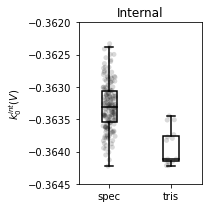

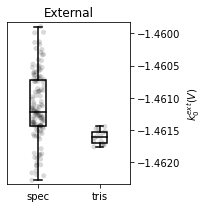

In [14]:
# df_k0 = pd.DataFrame([k0int_spec, k0ext_spec, k0int_tris, k0ext_tris])
df_k0int = pd.DataFrame({'spec': k0int_spec.dropna().reset_index(drop = True), 
                         'tris': k0int_tris.dropna().reset_index(drop = True), 
                        })

df_k0ext = pd.DataFrame({'spec': k0ext_spec.dropna().reset_index(drop = True), 
                         'tris': k0ext_tris.dropna().reset_index(drop = True),
                        })

# Internal
fig, axs = plt.subplots(figsize = (3, 3))
bplot=sns.boxplot(data=df_k0int, # main boxplot
                  width=0.25,
                  fliersize=0, # fliers are shown in stripplots
                  )

bplot=sns.stripplot(data=df_k0int, # add stripplot to boxplot with jitter
                   jitter=True, 
                   marker='o', 
                   alpha=0.15,
                   color='black')
axs.set_ylabel(r'$k_0^{int} (V)$')
axs.set_ylim([-0.3645, -0.3620])
yi1, yi2 = axs.get_ylim()
print(yi1-yi2)
axs.set_title('Internal')
plt.setp(axs.artists, edgecolor = 'k', facecolor='w')
plt.setp(axs.lines, color='k')
plt.tight_layout()
plt.savefig('Figures/k0int_boxwhisker.tiff', dpi = 1000, bbox_inches = 'tight')

# External
fig, axs = plt.subplots(figsize = (3, 3))
bplot=sns.boxplot(data=df_k0ext, # main boxplot
                  width=0.25,
                  fliersize=0, # fliers are shown in stripplots
                  )

bplot=sns.stripplot(data=df_k0ext, # add stripplot to boxplot with jitter
                   jitter=True, 
                   marker='o', 
                   alpha=0.15,
                   color='black')
axs.set_ylabel(r'$k_0^{ext} (V)$')
axs.set_ylim([-1.46233, -1.45983])
yi1, yi2 = axs.get_ylim()
print(yi1-yi2)
axs.set_title('External')
plt.setp(axs.artists, edgecolor = 'k', facecolor='w')
plt.setp(axs.lines, color='k')

# Put k0ext labels, ticks on right side
axs.yaxis.set_label_position('right')
axs.yaxis.tick_right()
plt.tight_layout()
plt.savefig('Figures/k0ext_boxwhisker.tiff', dpi = 1000, bbox_inches = 'tight')


print(df_k0int.describe())
print()
print(df_k0ext.describe())

### Use these standard deviations to calculate how many samples for given uncertainty

### Set up functions
- Calculate pHint, pHext using k0int, k0ext

In [15]:
def pHint_from_Vint_k0int(k0int, Vint, T_C):
    # See Martz et al. 2010, Bresnahan et al. 2014 for greater detail
    '''
    Inputs
        Internal ref voltage (V)
        Calibration coefficient, k0int (0 ºC value)
        Measured T (C)
    
    Outputs
        pHint (total scale)
    '''
    
    # Lumped, converted quantities
    T_K = T_C+273.15 # used often enough to warrant new variable
    S_Nernst = (R*T_K)/F*np.log(10) # ditto ^^^
    
    # Nernstian pH calculation
    pHint_tot = (Vint-(k0int+k2_int*(T_C-0)))/S_Nernst # Calc pHint from Nernst, the "-0" added explicitly intentionally
    
    return pHint_tot

def pHext_from_Vext_k0ext(k0ext, Vext, T_C, sal):
    # See Martz et al. 2010, Bresnahan et al. 2014 for greater detail
    '''
    Inputs
        External ref voltage (V)
        Calibration coefficient, k0ext (0 ºC value)
        Measured T (C)
        Salinity (PSU)
    
    Outputs
        pHext (total scale)
    '''
    
    # Lumped, converted quantities
    T_K = T_C+273.15 # used often enough to warrant new variable
    S_Nernst = (R*T_K)/F*np.log(10) # ditto ^^^
    
    # Physical chemistry calcs based on temp and salinity
    Z = 19.924*sal/(1000-1.005*sal) # Ionic strength, Dickson et al. 2007
    SO4_tot = (0.14/96.062)*(sal/1.80655) # Total conservative sulfate
    cCl = 0.99889/35.453*sal/1.80655 # Conservative chloride
    mCl = cCl*1000/(1000-sal*35.165/35) # mol/kg-H2O
    K_HSO4 = np.exp(-4276.1/T_K+141.328-23.093*np.log(T_K)
                    +(-13856/T_K+324.57-47.986*np.log(T_K))*Z**0.5
                    +(35474/T_K-771.54+114.723*np.log(T_K))*Z-2698/T_K*Z**1.5
                    +1776/T_K*Z**2+np.log(1-0.001005*sal)) # Bisulfate equilibrium const., Dickson et al. 2007
    DHconst = 0.00000343*T_C**2+0.00067524*T_C+0.49172143 # Debye-Huckel, Khoo et al. 1977
    log10gamma_HCl = 2*(-DHconst*np.sqrt(Z)/(1+1.394*np.sqrt(Z))+(0.08885-0.000111*T_C)*Z)
    
    # Nernstian pH calculations
    pHext_free = -(((k0ext+k2_ext*(T_C-0))-Vext)-S_Nernst*(np.log10(mCl)+log10gamma_HCl))/S_Nernst # mol/kg-H2O
    pHext_free = pHext_free-np.log10((1000-sal*35.165/35)/1000) # mol/kg-sw
    pHext_tot = pHext_free-np.log10(1+SO4_tot/K_HSO4)
    
    return pHext_tot

# Calculate pH_int and ext from various k0 inputs
pH_int_tris = pHint_from_Vint_k0int(k0int_tris.mean(), df_SCS.Vint, df_SCS.pHTemp)
pH_ext_tris = pHext_from_Vext_k0ext(k0ext_tris.mean(), df_SCS.VextRef, df_SCS.pHTemp, df_SCS.Salinity)

pH_int_spec = pHint_from_Vint_k0int(k0int_spec.mean(), df_SCS.Vint, df_SCS.pHTemp)
pH_ext_spec = pHext_from_Vext_k0ext(k0ext_spec.mean(), df_SCS.VextRef, df_SCS.pHTemp, df_SCS.Salinity)

### Calculate sensor pH at discrete sample times
- interpolate onto common timestamp, calculate ∆ (pHsensor-pHdisc)

In [16]:
pH_int_tris_disctime = np.interp(time_disc, df_SCS.index, pH_int_tris, left = np.nan, right = np.nan)
pH_ext_tris_disctime = np.interp(time_disc, df_SCS.index, pH_ext_tris, left = np.nan, right = np.nan)
pH_int_spec_disctime = np.interp(time_disc, df_SCS.index, pH_int_spec, left = np.nan, right = np.nan)
pH_ext_spec_disctime = np.interp(time_disc, df_SCS.index, pH_ext_spec, left = np.nan, right = np.nan)

delta_pH_int_tris_disc = pH_int_tris_disctime-df_spec.pHinsitu_corr
delta_pH_ext_tris_disc = pH_ext_tris_disctime-df_spec.pHinsitu_corr
delta_pH_int_spec_disc = pH_int_spec_disctime-df_spec.pHinsitu_corr
delta_pH_ext_spec_disc = pH_ext_spec_disctime-df_spec.pHinsitu_corr

### Plot pH time-series
- SCS results
  - cal with tris
  - cal with autosampler
- discrete, auto-sampler vals

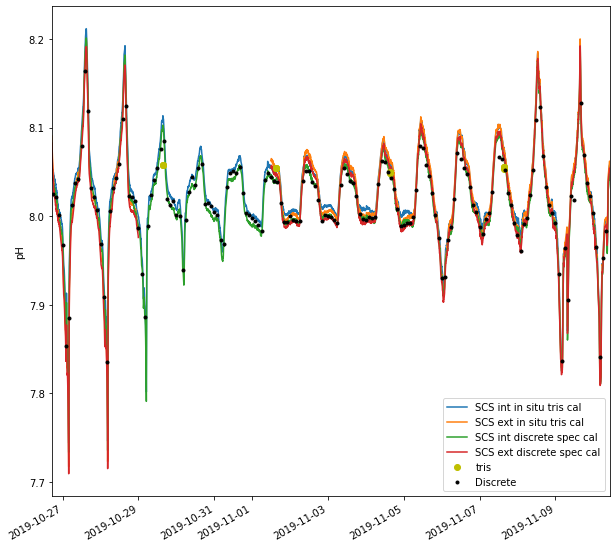

In [17]:
# Plot pH time-series
fig, axs = plt.subplots(figsize = (10, 10), nrows = 1, sharex = True)

axs.plot(df_SCS.index, pH_int_tris, label = 'SCS int in situ tris cal')
axs.plot(df_SCS.index, pH_ext_tris, label = 'SCS ext in situ tris cal')

axs.plot(df_SCS.index, pH_int_spec, label = 'SCS int discrete spec cal')
axs.plot(df_SCS.index, pH_ext_spec, label = 'SCS ext discrete spec cal')

axs.plot(df_tris.index, df_tris.pHintmeank0, 'yo', label = 'tris')

axs.plot(df_spec.index, df_spec.pHinsitu_corr, 'k.', label = 'Discrete')

axs.set_ylabel('pH')
axs.set_xlim([min(df_SCS.index), max(df_SCS.index)])

axs.legend()
fig.autofmt_xdate()

### Plot time-series of sensor and sensor-disc anomaly
- top subplot same as above
- add anomaly figure

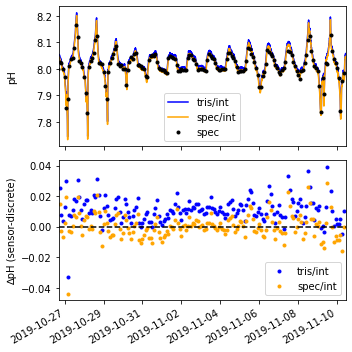

In [18]:
# Plot pH time-series, internal reference
fig, axs = plt.subplots(figsize = (5, 5), nrows = 2, sharex = True)

# Sensor, discrete time-series
axs[0].plot(df_SCS.index, pH_int_tris, 'b', label = 'tris/int')
axs[0].plot(df_SCS.index, pH_int_spec, 'orange', label = 'spec/int')
axs[0].plot(df_spec.index, df_spec.pHinsitu_corr, 'k.', label = 'spec')
axs[0].set_ylabel('pH')
axs[0].set_xlim([min(df_SCS.index), max(df_SCS.index)])
axs[0].legend()

# Anomaly time-series
axs[1].plot(df_spec.index, delta_pH_int_tris_disc, 'b.', label = 'tris/int')
axs[1].plot(df_spec.index, delta_pH_int_spec_disc, color = 'orange', marker = '.', linestyle = 'none', label = 'spec/int')
axs[1].plot([min(df_SCS.index), max(df_SCS.index)], [0, 0], 'k--')
axs[1].set_ylabel('∆pH (sensor-discrete)')
axs[1].legend()

# xtick dates are poorly spaced
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(2))

# Final formatting
fig.autofmt_xdate()
fig.align_ylabels()
plt.tight_layout()

# Save
plt.savefig('Figures/stacked_pH_anom_int.jpg', dpi = 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


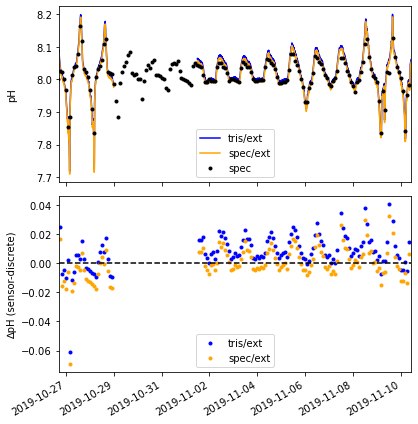

In [19]:
# Plot pH time-series, external reference
fig, axs = plt.subplots(figsize = (6, 6), nrows = 2, sharex = True)

# Sensor, discrete time-series
axs[0].plot(df_SCS.index, pH_ext_tris, 'b', label = 'tris/ext')
axs[0].plot(df_SCS.index, pH_ext_spec, 'orange', label = 'spec/ext')
axs[0].plot(df_spec.index, df_spec.pHinsitu_corr, 'k.', label = 'spec')
axs[0].set_ylabel('pH')
axs[0].set_xlim([min(df_SCS.index), max(df_SCS.index)])
axs[0].legend()

# Anomaly time-series
axs[1].plot(df_spec.index, delta_pH_ext_tris_disc, 'b.', label = 'tris/ext')
axs[1].plot(df_spec.index, delta_pH_ext_spec_disc, color = 'orange', marker = '.', linestyle = 'none', label = 'spec/ext')
axs[1].plot([min(df_SCS.index), max(df_SCS.index)], [0, 0], 'k--')
axs[1].set_ylabel('∆pH (sensor-discrete)')
axs[1].legend(loc = 'lower center')

# xtick dates are poorly spaced
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(2))

# Final formatting
fig.autofmt_xdate()
fig.align_ylabels()
plt.tight_layout()

# Save
plt.savefig('Figures/stacked_pH_anom_ext.eps', dpi = 600)

### pH anomaly stats

In [20]:
rmse_int_tris = np.sqrt(np.sum((pH_int_tris_disctime-df_spec.pHinsitu_corr)**2)/(len(pH_int_tris_disctime)))
rmse_ext_tris = np.sqrt(np.sum((pH_ext_tris_disctime-df_spec.pHinsitu_corr)**2)/(len(pH_ext_tris_disctime)))
rmse_int_spec = np.sqrt(np.sum((pH_int_spec_disctime-df_spec.pHinsitu_corr)**2)/(len(pH_int_spec_disctime)))
rmse_ext_spec = np.sqrt(np.sum((pH_ext_spec_disctime-df_spec.pHinsitu_corr)**2)/(len(pH_ext_spec_disctime)))

print("Tris results")
print("∆pH (pH_int_tris-pH_disc) mean ± std: {} ± {}".format(delta_pH_int_tris_disc.mean(), delta_pH_int_tris_disc.std()))
print("∆pH (pH_ext_tris-pH_disc) mean ± std: {} ± {}".format(delta_pH_ext_tris_disc.mean(), delta_pH_ext_tris_disc.std()))
print("∆pH (pH_int_tris-pH_disc) RMSE: {}".format(rmse_int_tris))
print("∆pH (pH_ext_tris-pH_disc) RMSE: {}".format(rmse_ext_tris))
print("Tris n = {}".format(delta_pH_int_tris_disc.count()))

print("\n")

print("Autosampler results")
print("∆pH (pH_int_spec-pH_disc) mean ± std: {} ± {}".format(delta_pH_int_spec_disc.mean(), delta_pH_int_spec_disc.std()))
print("∆pH (pH_ext_spec-pH_disc) mean ± std: {} ± {}".format(delta_pH_ext_spec_disc.mean(), delta_pH_ext_spec_disc.std()))
print("∆pH (pH_int_spec-pH_disc) RMSE: {}".format(rmse_int_spec))
print("∆pH (pH_ext_spec-pH_disc) RMSE: {}".format(rmse_ext_spec))
print("Tris n = {}".format(delta_pH_ext_spec_disc.count()))

Tris results
∆pH (pH_int_tris-pH_disc) mean ± std: 0.011127687538302232 ± 0.00815766590871311
∆pH (pH_ext_tris-pH_disc) mean ± std: 0.008059897319570719 ± 0.011593793058319332
∆pH (pH_int_tris-pH_disc) RMSE: 0.01198882533569241
∆pH (pH_ext_tris-pH_disc) RMSE: 0.010628939094131151
Tris n = 174


Autosampler results
∆pH (pH_int_spec-pH_disc) mean ± std: 0.0005350128893886171 ± 0.008166663415296392
∆pH (pH_ext_spec-pH_disc) mean ± std: 0.00013555028397580933 ± 0.011602860263561566
∆pH (pH_int_spec-pH_disc) RMSE: 0.007098050942329289
∆pH (pH_ext_spec-pH_disc) RMSE: 0.008723739374896709
Tris n = 131


### Stacked plot with aux vars
Aux is relative; show T, S, P, DO

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


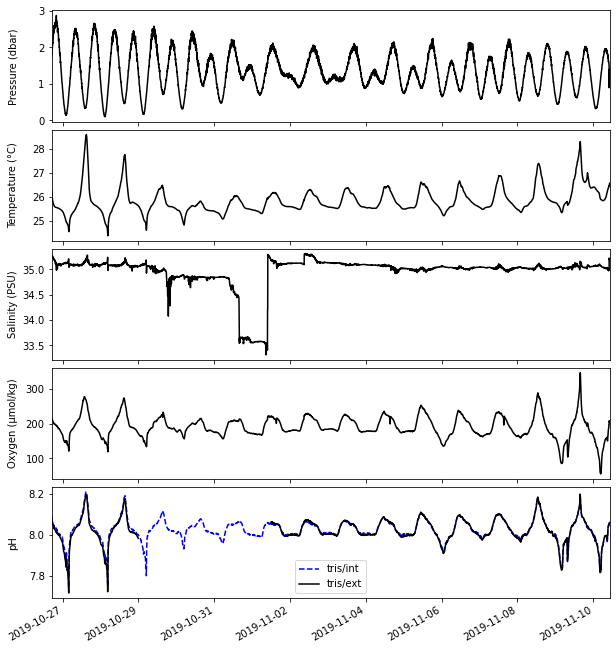

In [21]:
# Plot time-series
fig, axs = plt.subplots(figsize = (10, 12), nrows = 5, sharex = True)
plt.subplots_adjust(hspace = 0.07)

axs[0].plot(df_SCS.index, df_SCS.Pressure_dBar_, 'k-')
axs[0].set_ylabel('Pressure (dbar)')

axs[1].plot(df_SCS.index, df_SCS.pHTemp, 'k-')
axs[1].set_ylabel('Temperature (°C)')

axs[2].plot(df_SCS.index, df_SCS.Salinity, 'k-')
axs[2].set_ylabel('Salinity (PSU)')

axs[3].plot(df_SCS.index, df_SCS.OxygenUM, 'k-')
axs[3].set_ylabel('Oxygen (µmol/kg)')

# Sensor, discrete time-series
axs[4].plot(df_SCS.index, pH_int_tris, 'b--', label = 'tris/int')
axs[4].plot(df_SCS.index, pH_ext_tris, 'k-', label = 'tris/ext')
axs[4].legend(loc = 'lower center')

axs[4].set_ylabel('pH')
axs[4].set_xlim([min(df_SCS.index), max(df_SCS.index)])

# xtick dates are poorly spaced
axs[4].xaxis.set_major_locator(ticker.MultipleLocator(2))

# Final formatting
fig.autofmt_xdate()
fig.align_ylabels()
# plt.tight_layout()

# Save
plt.savefig('Figures/stacked_ts.eps', dpi = 600, bbox_inches = 'tight')

In [22]:
print("Mean temp and pressure are {} and {}".format(df_SCS.pHTemp.mean(), df_SCS.Pressure_dBar_.mean()))

Mean temp and pressure are 25.827688222799235 and 1.3565456691055024


In [23]:
print(df_SCS.index.min())
print(df_SCS.index.max())

2019-10-26 17:05:10
2019-11-10 10:25:10


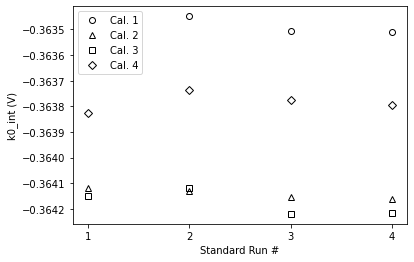

In [24]:
fig, axs = plt.subplots()
# First point is removed due to seawater contamination
axs.plot(range(2, 5), k0int_tris[0:3], 'ko', fillstyle='none', label = 'Cal. 1')
axs.plot(range(1, 5), k0int_tris[3:7], 'k^', fillstyle='none', label = 'Cal. 2')
axs.plot(range(1, 5), k0int_tris[7:11], 'ks', fillstyle='none', label = 'Cal. 3')
axs.plot(range(1, 5), k0int_tris[11:15], 'kD', fillstyle='none', label = 'Cal. 4')

axs.set_ylabel('k0_int (V)')
axs.set_xticks([1, 2, 3, 4])
axs.set_xlabel('Standard Run #')
axs.legend()

### Calculate an average Nernst slope
Expected to be close to -59 mV/pH unit

In [25]:
T_K = df_SCS.pHTemp.mean()+273.15
S_Nernst = (R*T_K)/F*np.log(10)
S_Nernst

0.05932289336056938

### Calculate pH uncertainty using uncertainties in k0 and Nernst slope

In [26]:
pH_int_tris_std = k0int_tris.std()/S_Nernst
pH_ext_tris_std = k0ext_tris.std()/S_Nernst

pH_int_spec_std = k0int_spec.std()/S_Nernst
pH_ext_spec_std = k0ext_spec.std()/S_Nernst

print("pH int tris stdev is ", pH_int_tris_std)
print("pH ext tris stdev is ", pH_ext_tris_std)

print("pH int auto stdev is ", pH_int_spec_std)
print("pH ext auto stdev is ", pH_ext_spec_std)

pH int tris stdev is  0.004725901625051708
pH ext tris stdev is  0.0017729398495140432
pH int auto stdev is  0.006232914228473661
pH ext auto stdev is  0.008955510545705954


### Calculate a difference in reported pH values using calculated k0s and Nernst slope

In [27]:
pH_methodological_difference = (k0ext_tris.mean()-k0ext_spec.mean())/S_Nernst
print(pH_methodological_difference)
print(k0ext_tris.mean()-k0ext_spec.mean())

-0.00792597163664296
-0.0004701915701794679
